# This code reads hallubench dataset csv file with answers column and evaluate the answers using RAGAS with Ollama-Llama 3 model local through Langchain Ollama. LLama 3.1 doesn't work (can't calculate faithfulness)

In [ ]:
#@title { vertical-output: true}
# Installation
!pip install -q langchain langchain-community sentence-transformers datasets huggingface_hub ragas==0.1.21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#@title { vertical-output: true}
# Imports
import os
from datasets import Dataset
from langchain_community.llms import Ollama
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, answer_correctness
from langchain.embeddings import HuggingFaceEmbeddings
import pandas as pd

In [ ]:
#@title { vertical-output: true}
# Install ollama: The Ollama API is now available at 127.0.0.1:11434
! curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
#@title { vertical-output: true}
import subprocess
process = subprocess.Popen("ollama serve", shell=True)
# credit: https://stackoverflow.com/questions/78437376/run-ollama-run-llama3-in-colab-raise-err-error-could-not-connect-to-ollama

# download the Llama3 model for evaluation
!ollama pull llama3

pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠧ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏  29 KB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏ 5.0 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   2% ▕▏  84 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   3% ▕▏ 128 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   5% ▕▏ 229 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   7% ▕▏ 337 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   8% ▕▏ 394 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...  11% ▕▏ 503 MB/4.7 GB                  pulling manifest 
pullin

In [ ]:
#@title { vertical-output: true}
# Initialize Ollama with Llama 3
langchain_llm = Ollama(
    model="llama3",
    temperature=0.1,
    num_ctx=8096,  # Context window size
    num_thread=8,  # Number of threads to use
    verbose=True,
    timeout=None
)


In [ ]:
#@title { vertical-output: true}
# Initialize HuggingFaceEmbeddings
langchain_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

<ipython-input-7-f8e42a0f580a>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  langchain_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warning

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#@title { vertical-output: true}
# Load your DataFrame (assuming you have a CSV file)
df = pd.read_csv('/content/halubench_RagTruth_EnhancedRAG_pass.csv')

In [ ]:
#@title { vertical-output: true}
# Preprocess the DataFrame
def preprocess_dataframe(df):
    df['ground_truth'] = df['ground_truth'].apply(
        lambda x: ' '.join(x) if isinstance(x, list) else str(x)
    )
    df['question'] = df['question'].astype(str)
    df['answer'] = df['answer'].astype(str)
    df['contexts'] = df['contexts'].apply(lambda x: [str(item) for item in x] if isinstance(x, list) else [str(x)])
    return df

df = preprocess_dataframe(df)

# Create the ragas_data dictionary
ragas_data = {
    "question": df['question'].tolist(),
    "contexts": df['contexts'].tolist(),
    "answer": df['answer'].tolist(),
    "ground_truth": df['ground_truth'].tolist()
}

# Convert to Dataset object
ragas_dataset_llm = Dataset.from_dict(ragas_data)

In [ ]:
#@title { vertical-output: true}
# Run RAGAS evaluation
result_llm = evaluate(
    dataset=ragas_dataset_llm,
    metrics=[
        faithfulness,
        answer_relevancy,
        answer_correctness
    ],
    llm=langchain_llm,
    embeddings=langchain_embeddings
)

print(result_llm)

Evaluating:   0%|          | 0/2220 [00:00<?, ?it/s]

{'faithfulness': 0.8855, 'answer_relevancy': 0.7838, 'answer_correctness': 0.5536}


In [ ]:

result_llm.to_pandas().to_csv('ragas_ragtruth_enhancedRag_pass.csv', index=False)
result_llm_df=result_llm.to_pandas()
result_llm_df.head()

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,answer_correctness
0,how do automotive technicians get paid,"[passage 1:In short, whether mechanics and tec...",Automotive technicians can be paid through va...,Automotive technicians can be paid in various ...,1.0,0.694164,0.496724
1,how do automotive technicians get paid,"[passage 1:In short, whether mechanics and tec...",Automotive technicians can be paid through va...,Automotive technicians can be paid through a c...,1.0,0.694164,0.554584
2,how do automotive technicians get paid,"[passage 1:In short, whether mechanics and tec...",Automotive technicians can be paid through va...,Unable to answer based on given passages.,1.0,0.694164,-0.017208
3,how do automotive technicians get paid,"[passage 1:In short, whether mechanics and tec...",Automotive technicians can be paid through va...,"Based on the provided passages, here is the an...",1.0,0.954561,0.392390
4,how do automotive technicians get paid,"[passage 1:In short, whether mechanics and tec...",Automotive technicians can be paid through va...,"Based on the given passages, automotive techni...",1.0,0.694164,0.492764


In [ ]:

import google.colab

# Import necessary libraries
import os
from google.colab import files

# Specify the path to your CSV file in Colab
csv_file_path = '/content/ragas_ragtruth_enhancedRag_pass.csv'

# Check if the file exists
if os.path.exists(csv_file_path):
    # Download the file
    files.download(csv_file_path)
    print(f"File '{csv_file_path}' has been downloaded.")
else:
    print(f"Error: The file '{csv_file_path}' does not exist.")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File '/content/ragas_ragtruth_enhancedRag_pass.csv' has been downloaded.


In [ ]:
import time

print("Runtime will disconnect in 5 minutes...")
# Wait for 5 minutes (300 seconds)
time.sleep(300)

Runtime will disconnect in 5 minutes...


In [ ]:
import google.colab
from google.colab import runtime
import time

print("Runtime will disconnect in 5 minutes...")
# Wait for 5 minutes (300 seconds)
time.sleep(3000)

print("Disconnecting and deleting runtime...")
runtime.unassign()
print("Done. You can close this tab now.")

# Compare Evaluation

**DROP**

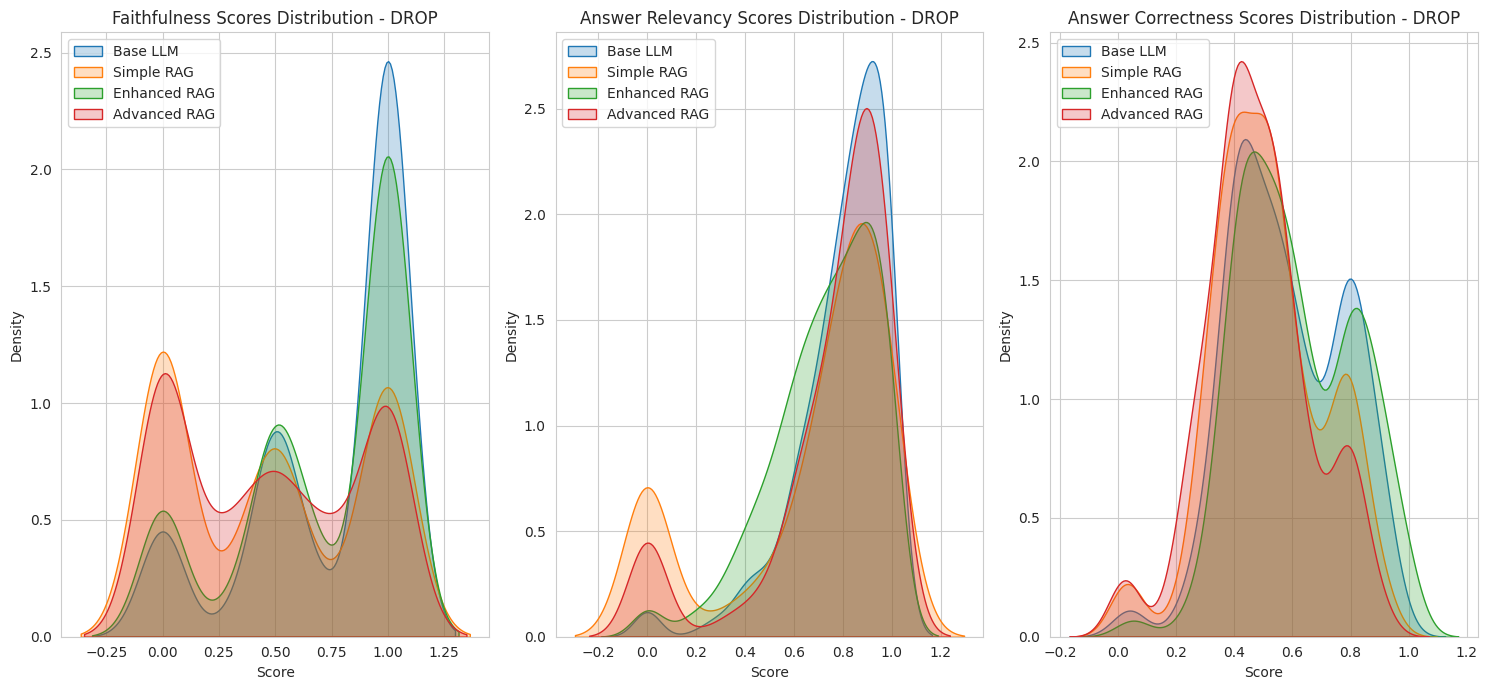

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def read_csv_files():
    return {
        'Base LLM': pd.read_csv('/content/ragas_drop_ollama_mistral_colab_pass.csv'),
        'Simple RAG': pd.read_csv('/content/ragas_Drop_SimpleRag_Mistral_1024.csv'),
        'Enhanced RAG': pd.read_csv('/content/ragas_drop_enhancedRag_colab_pass.csv'),
        'Advanced RAG': pd.read_csv('/content/ragas_drop_advancedRag_pass.csv')
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution - DROP')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

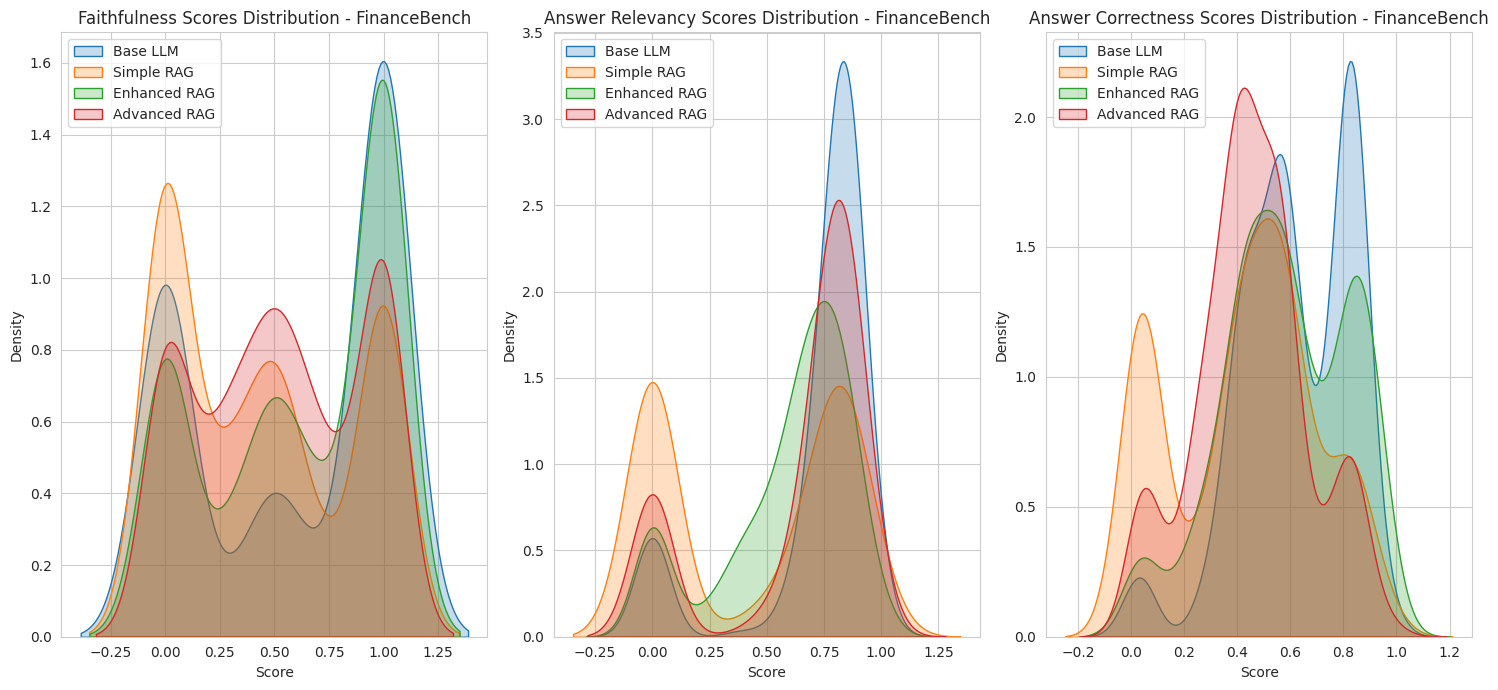

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Base LLM': pd.read_csv('/content/ragas_financebench_ollama_mistral_colab_pass.csv'),
        'Simple RAG': pd.read_csv('/content/ragas_financebench_SimpleRag_Mistral_1024.csv'),
        'Enhanced RAG': pd.read_csv('/content/ragas_financebench_enhancedRag_pass.csv'),
        'Advanced RAG': pd.read_csv('/content/ragas_financebench_advancedRag_pass.csv')
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution - FinanceBench')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

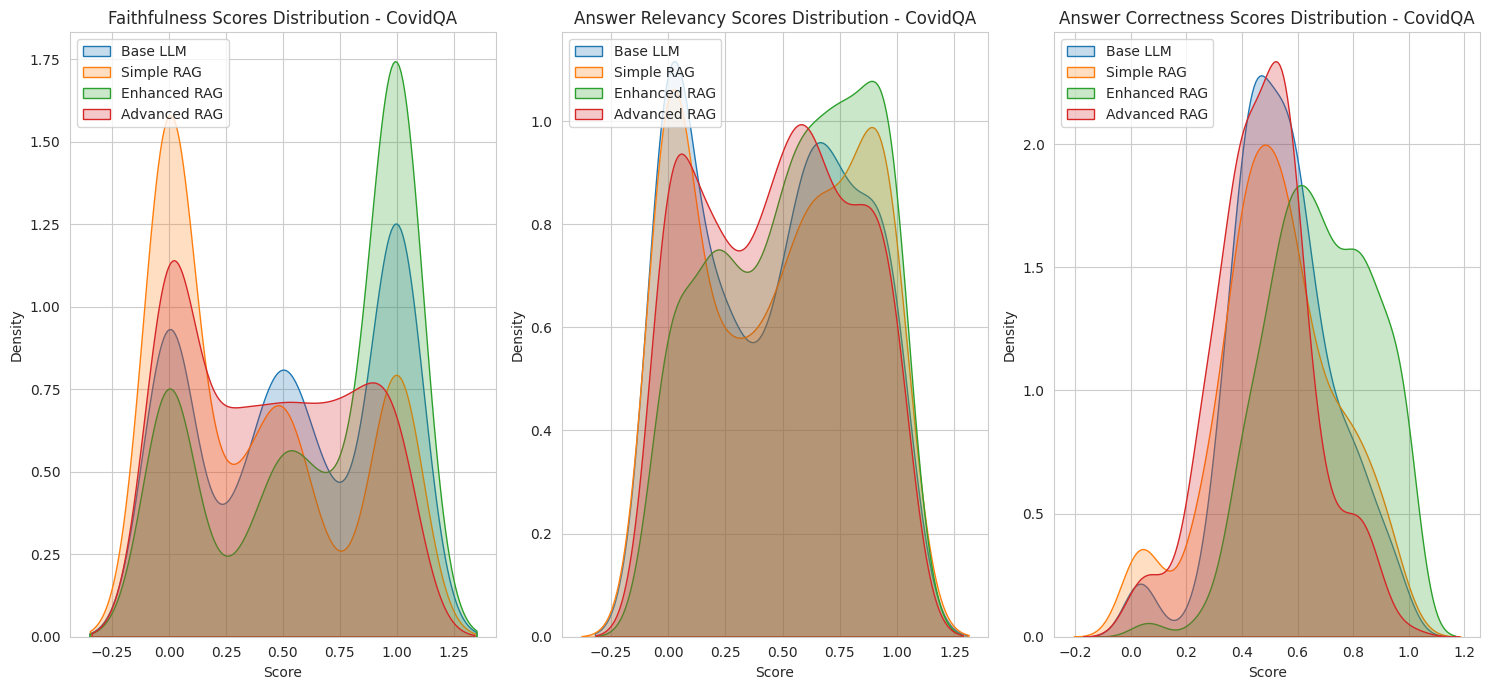

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Base LLM': pd.read_csv('/content/ragas_covidQA_ollama_mistral_colab_pass.csv'),
        'Simple RAG': pd.read_csv('/content/ragas_covidQA_SimpleRag_Mistral_1024.csv'),
        'Enhanced RAG': pd.read_csv('/content/ragas_covidQA_enhancedRag_pass.csv'),
        'Advanced RAG': pd.read_csv('/content/ragas_covidQA_advancedRag_pass.csv')
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution - CovidQA')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

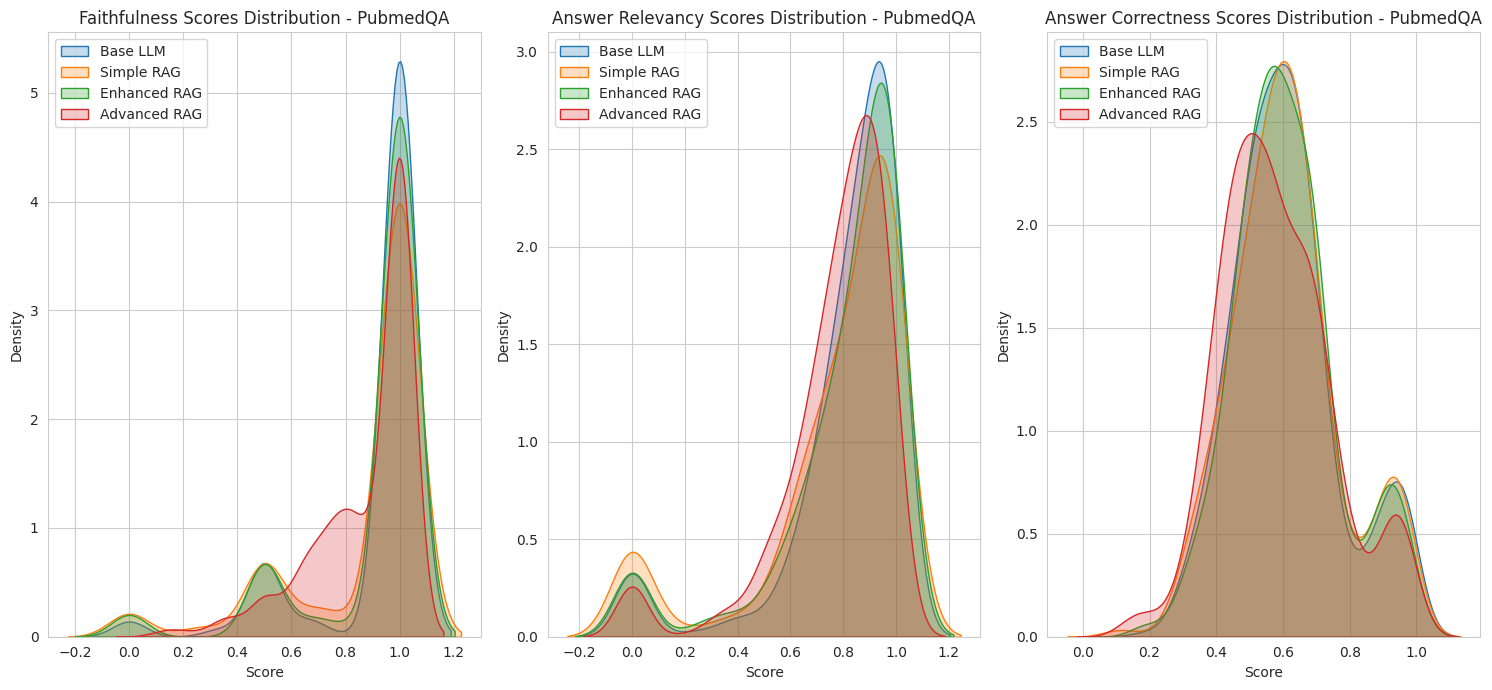

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Base LLM': pd.read_csv('/content/ragas_pubmedQA_mistral_colab_pass.csv'),
        'Simple RAG': pd.read_csv('/content/ragas_pubmedQA_SimpleRag_Mistral_1024.csv'),
        'Enhanced RAG': pd.read_csv('/content/ragas_pubmedQA_enhancedRag_pass.csv'),
        'Advanced RAG': pd.read_csv('/content/ragas_pubmedQA_advancedRag_pass.csv')
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution - PubmedQA')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

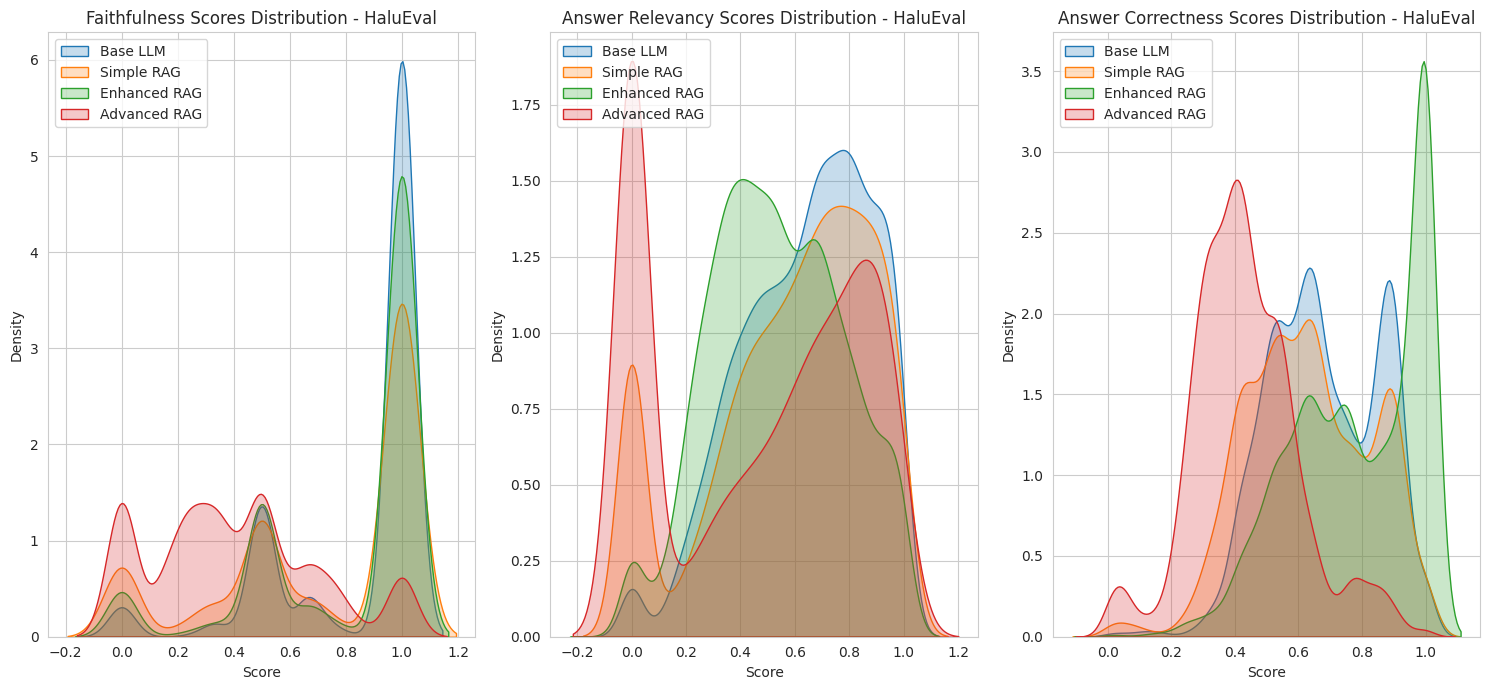

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Base LLM': pd.read_csv('/content/ragas_halueval_ollama_mistral_colab_pass.csv'),
        'Simple RAG': pd.read_csv('/content/ragas_HaluEval_SimpleRag_Mistral_1024.csv'),
        'Enhanced RAG': pd.read_csv('/content/ragas_halueval_enhancedRAG_pass.csv'),
        'Advanced RAG': pd.read_csv('/content/ragas_halueval_advancedRag_pass.csv')
    }
def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution - HaluEval')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

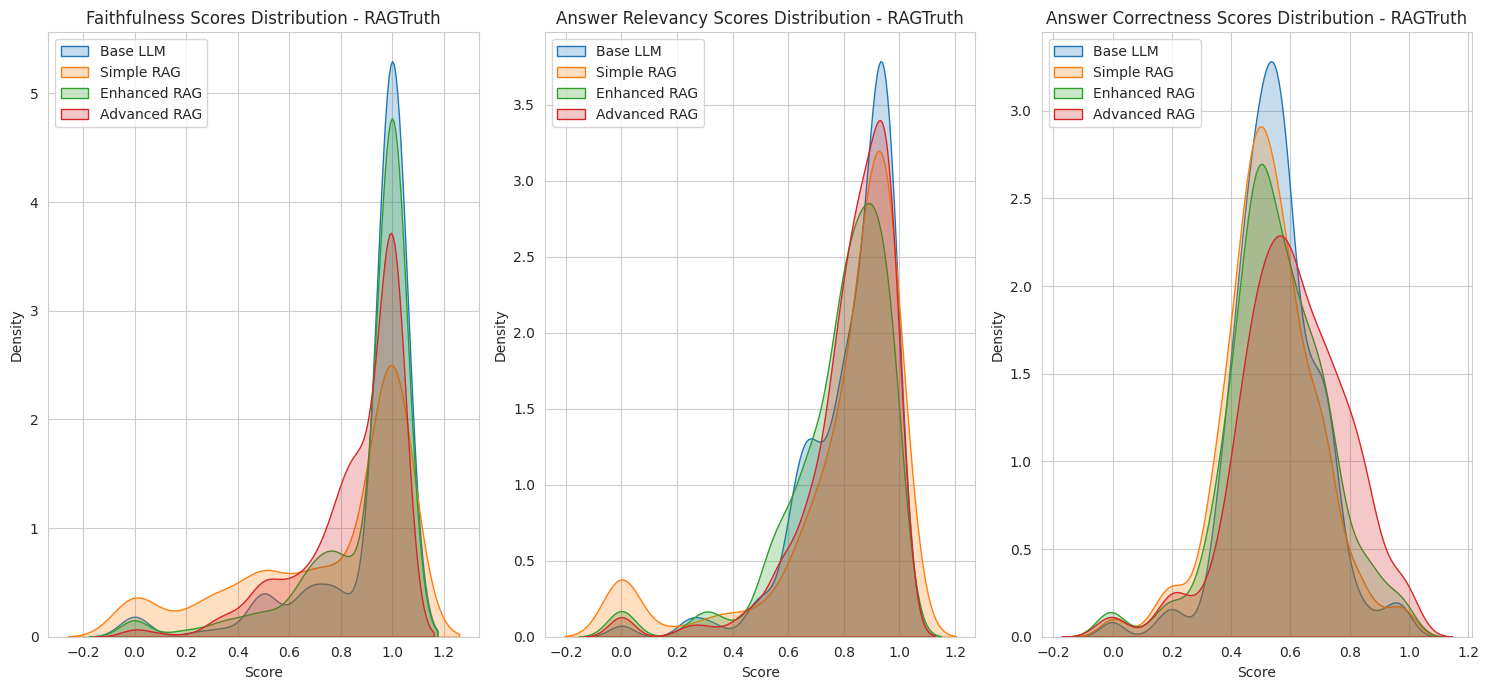

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Base LLM': pd.read_csv('/content/ragas_ragTruth_mistral_colab_pass.csv'),
        'Simple RAG': pd.read_csv('/content/ragas_RAGtruth_SimpleRag_Mistral_1024.csv'),
        'Enhanced RAG': pd.read_csv('/content/ragas_ragtruth_enhancedRag_pass.csv'),
        'Advanced RAG': pd.read_csv('/content/ragas_ragtruth_advancedRag_pass.csv')
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution - RAGTruth')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

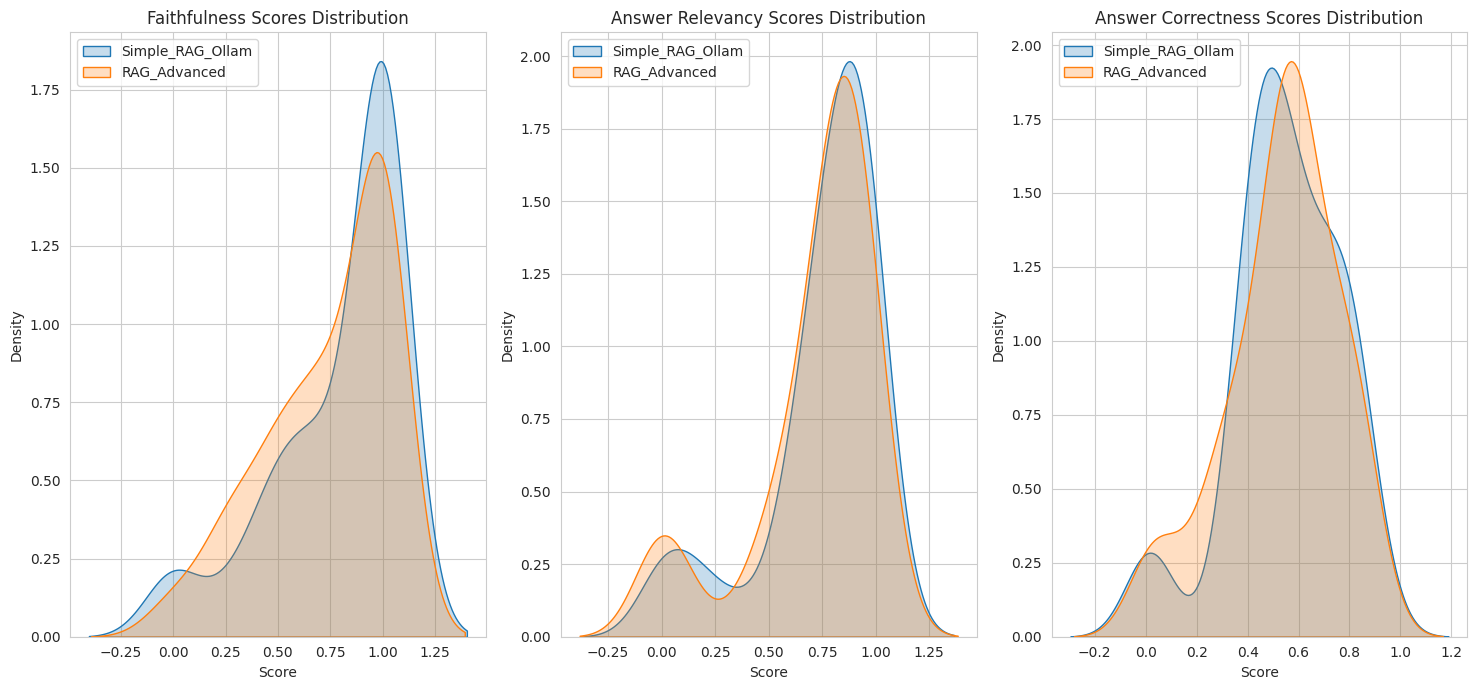

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Simple_RAG_Ollam': pd.read_csv('/content/ragas_halubench_short_results_simple_rag_ollama_A100.csv'),
        'RAG_Advanced': pd.read_csv('/content/ragas_halubench_short_results_newRAG_Advanced.csv'),
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

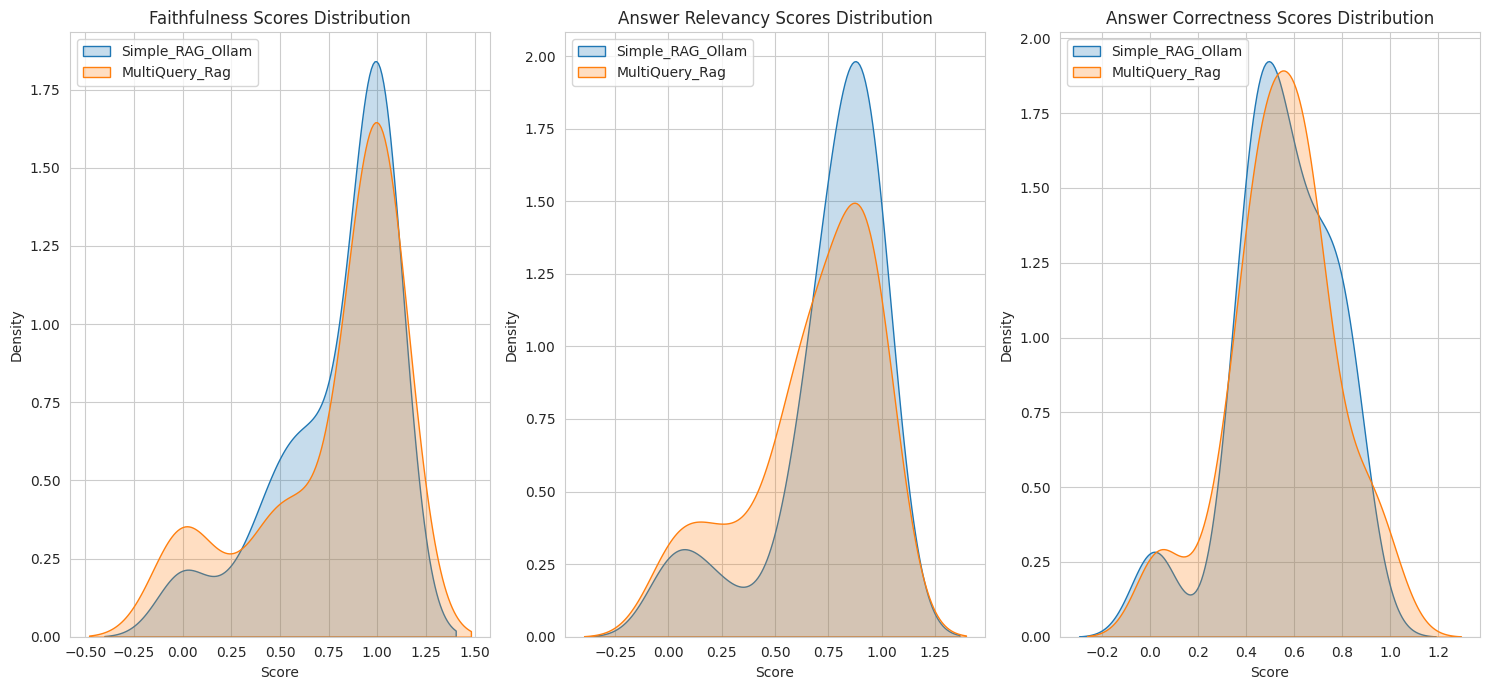

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Simple_RAG_Ollam': pd.read_csv('/content/ragas_halubench_short_results_simple_rag_ollama_A100.csv'),
        'MultiQuery_Rag': pd.read_csv('//content/ragas_halubench_short_results_Multiquery_RAG_Ollama_2.csv'),
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

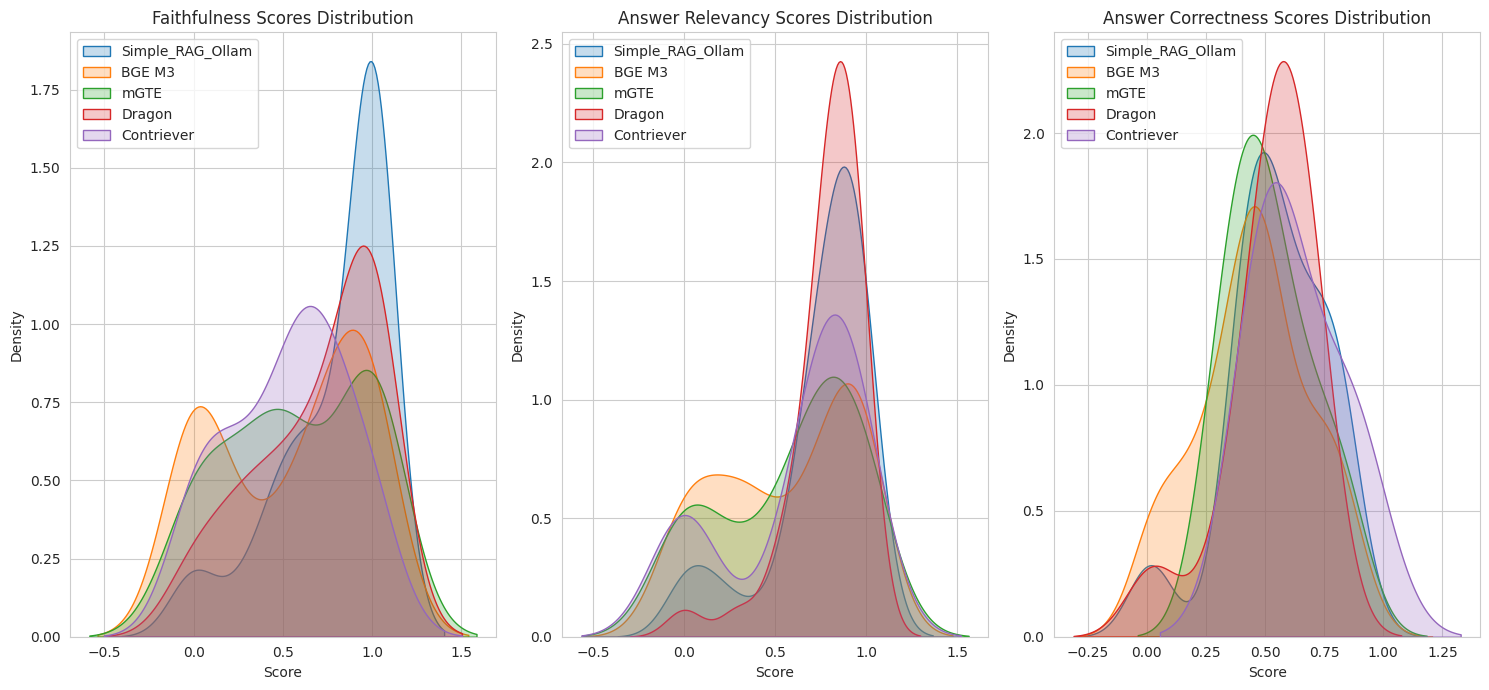

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Simple_RAG_Ollam': pd.read_csv('/content/ragas_halubench_short_results_simple_rag_ollama_A100.csv'),
        'BGE M3': pd.read_csv('/content/ragas_halubench_short_results_HybridSearch.csv'),
        'mGTE': pd.read_csv('/content/ragas_mGTE.csv'),
        'Dragon': pd.read_csv('/content/ragas_Dragon.csv'),
        'Contriever': pd.read_csv('/content/ragas_Contriever.csv')
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

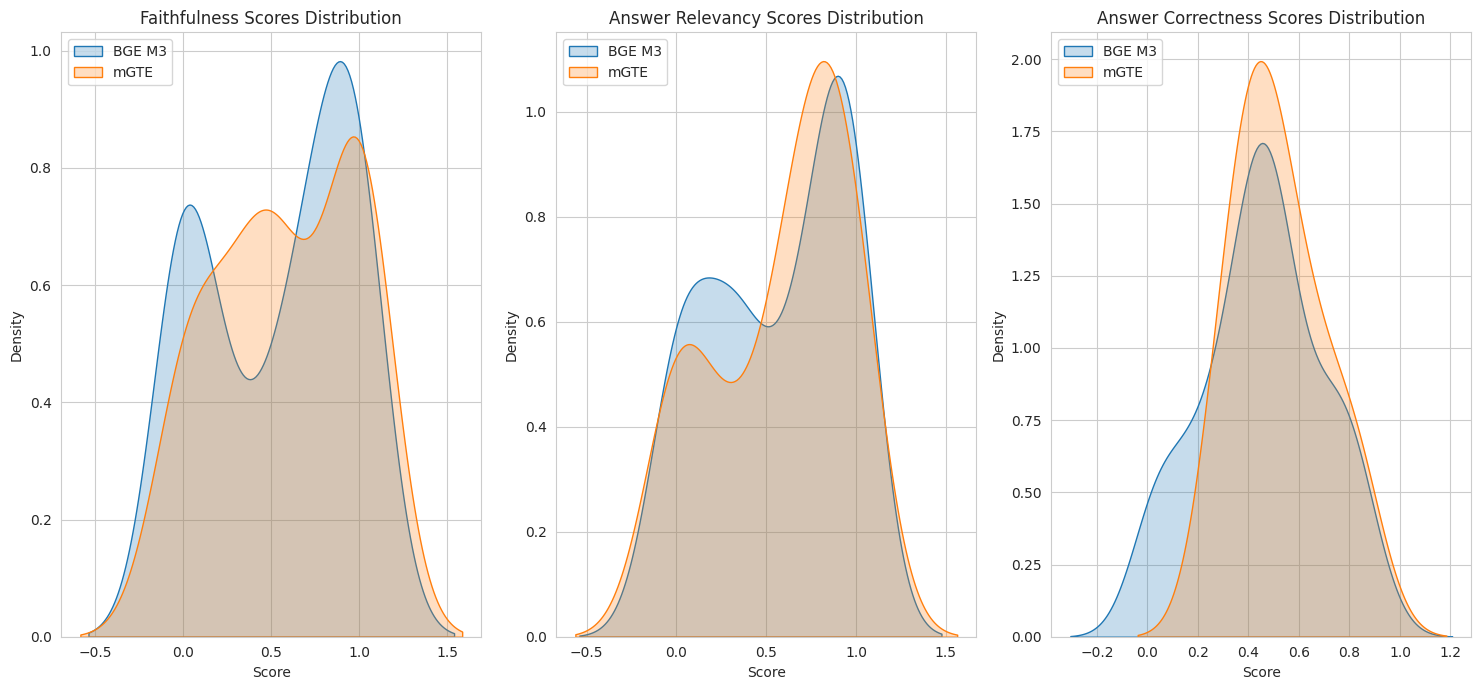

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'BGE M3': pd.read_csv('/content/ragas_halubench_short_results_HybridSearch.csv'),
        'mGTE': pd.read_csv('/content/ragas_mGTE.csv'),
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

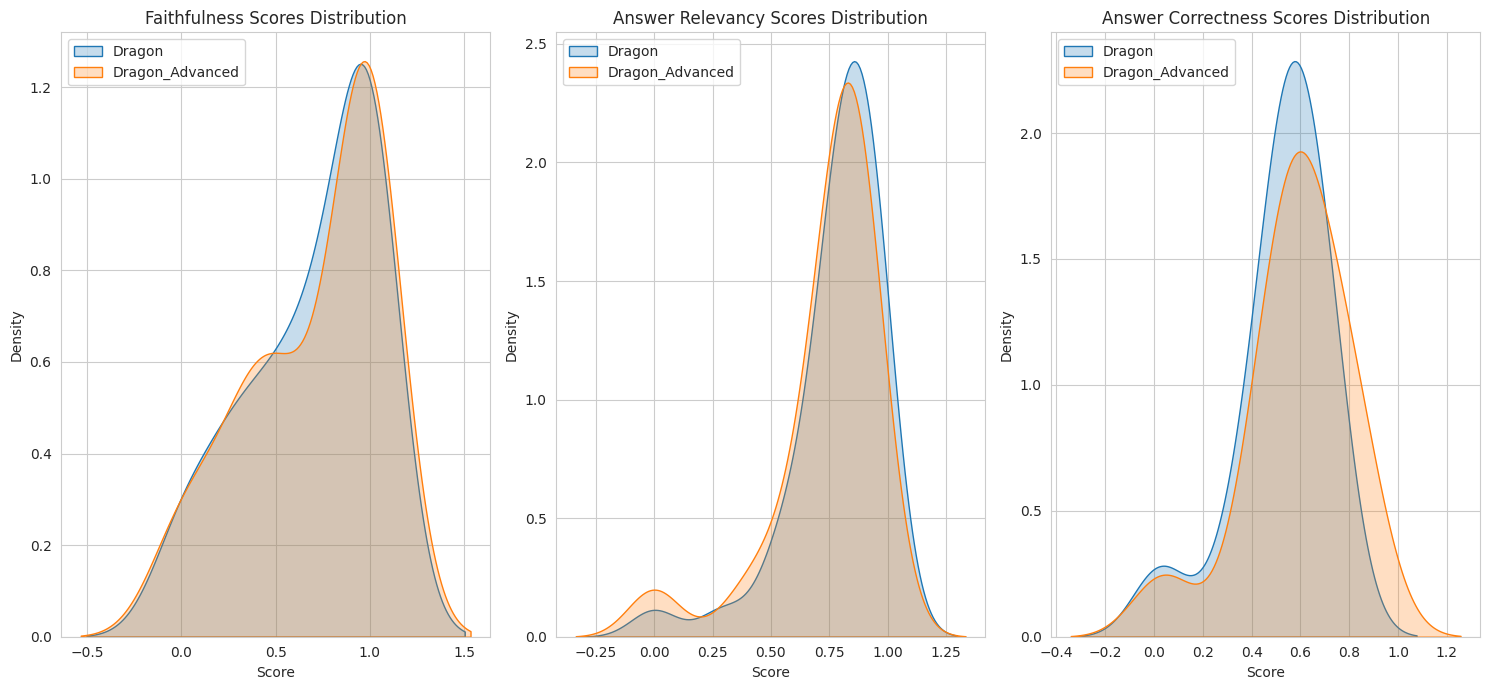

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Dragon': pd.read_csv('/content/ragas_Dragon.csv'),
        'Dragon_Advanced': pd.read_csv('/content/ragas_Dragon_Advanced.csv'),
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()